## Import Librerías

In [1]:
import pandas as pd
import seaborn as sns
from utils_r1 import FastTensorDataLoader, CoverTypeDataModule, MLP
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from sklearn.metrics import accuracy_score, f1_score

import pytorch_lightning as pl
pl.seed_everything(42, workers=True)
%matplotlib inline


Global seed set to 42


## Importación de los Datos

In [2]:
df = pd.read_csv('data/covtype.csv')
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


## EDA

El detalle del análisis exploratorio de datos se encuentra en el Informe en PDF.

In [3]:
NUM_VARS = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

CAT_VARS = [col for col in df.columns if col not in NUM_VARS]

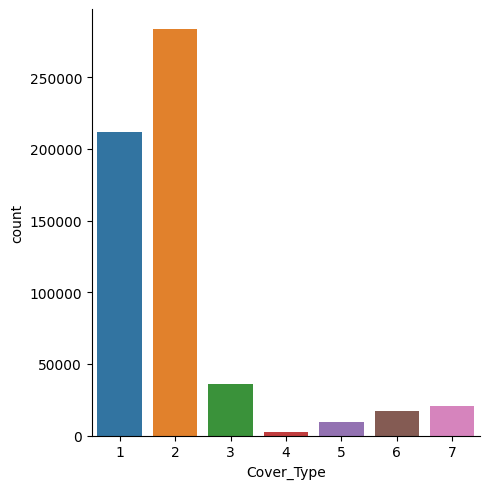

In [4]:
sns.catplot(x = 'Cover_Type', data = df, kind = 'count');

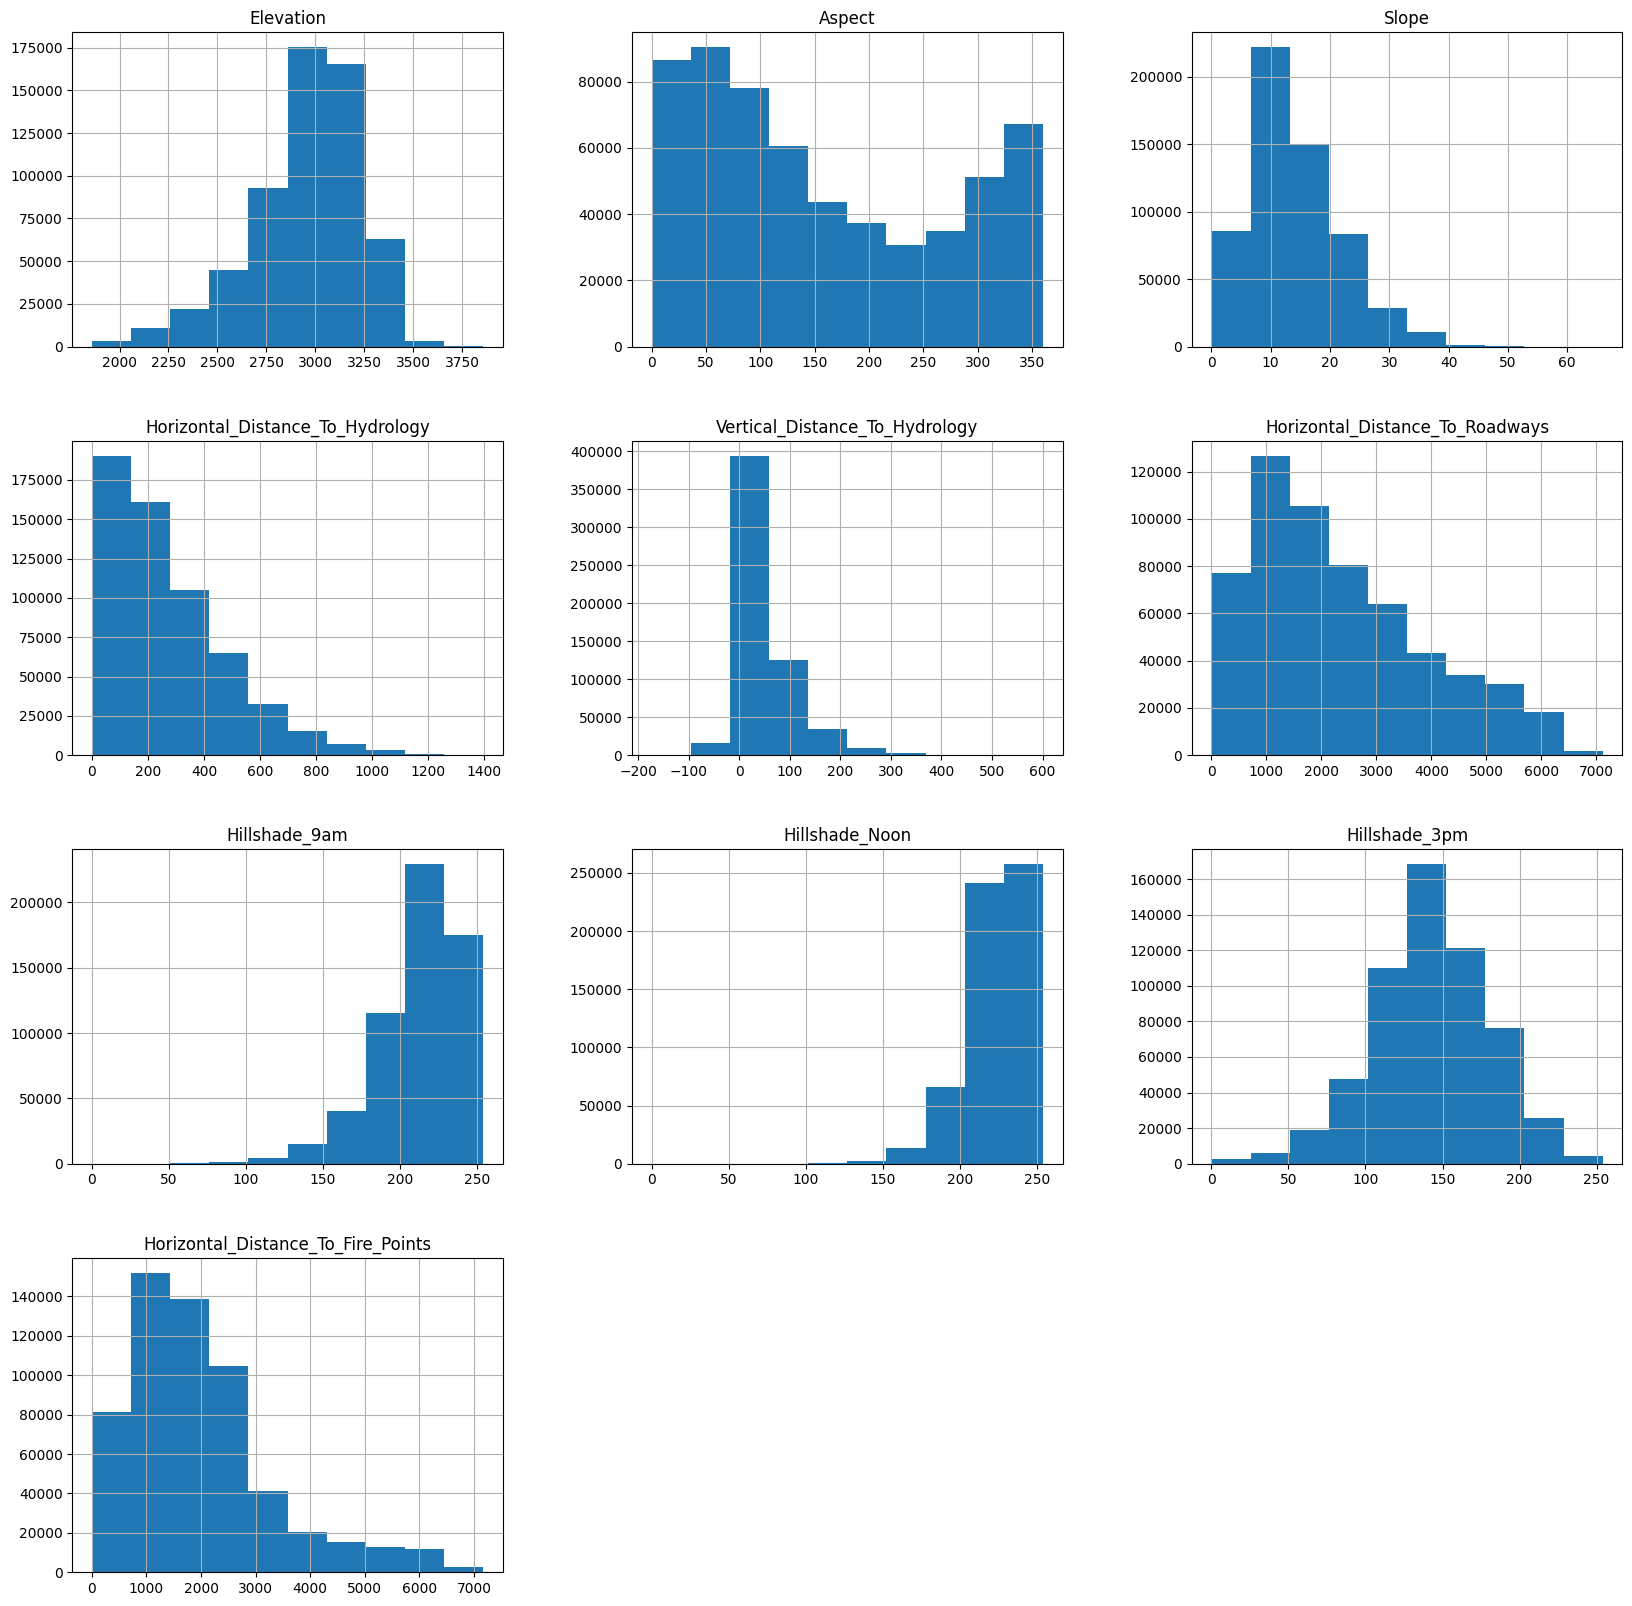

In [5]:
df[NUM_VARS].hist(figsize = (20,20));

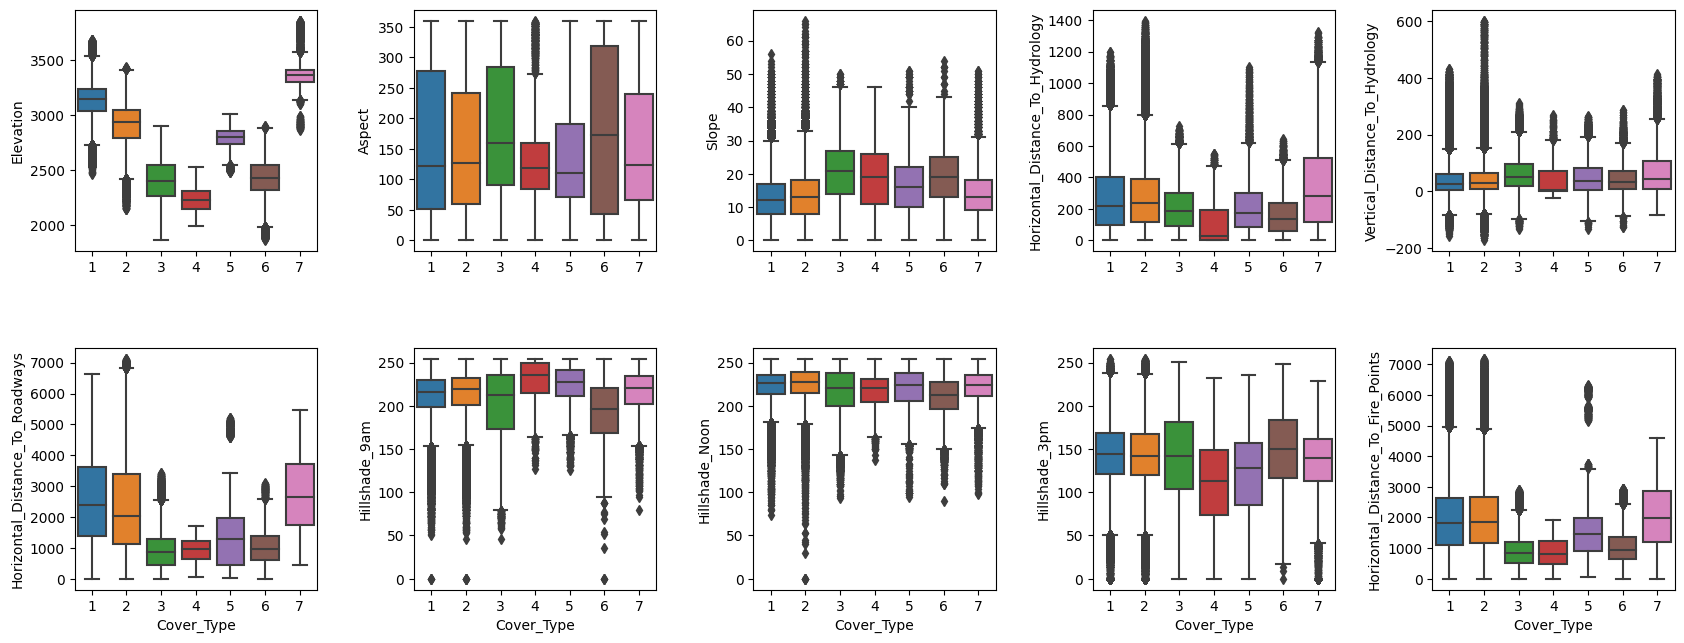

In [6]:
fig, axs = plt.subplots(2, 5, figsize = (20,2))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=3,
                    wspace=0.4,
                    hspace=0.4)

for i in range(2):
    for j in range(0,5):
        if 5*i + j >= 5:
            sns.boxplot(ax = axs[i,j], y = df.columns[5*i+j], x = "Cover_Type", data = df)
        else:
            sns.boxplot(ax = axs[i,j], y = df.columns[5*i+j], x = "Cover_Type", data = df).set(xlabel=None)



/tmp/ipykernel_38733/2547740407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Cover_Type"] = df.Cover_Type


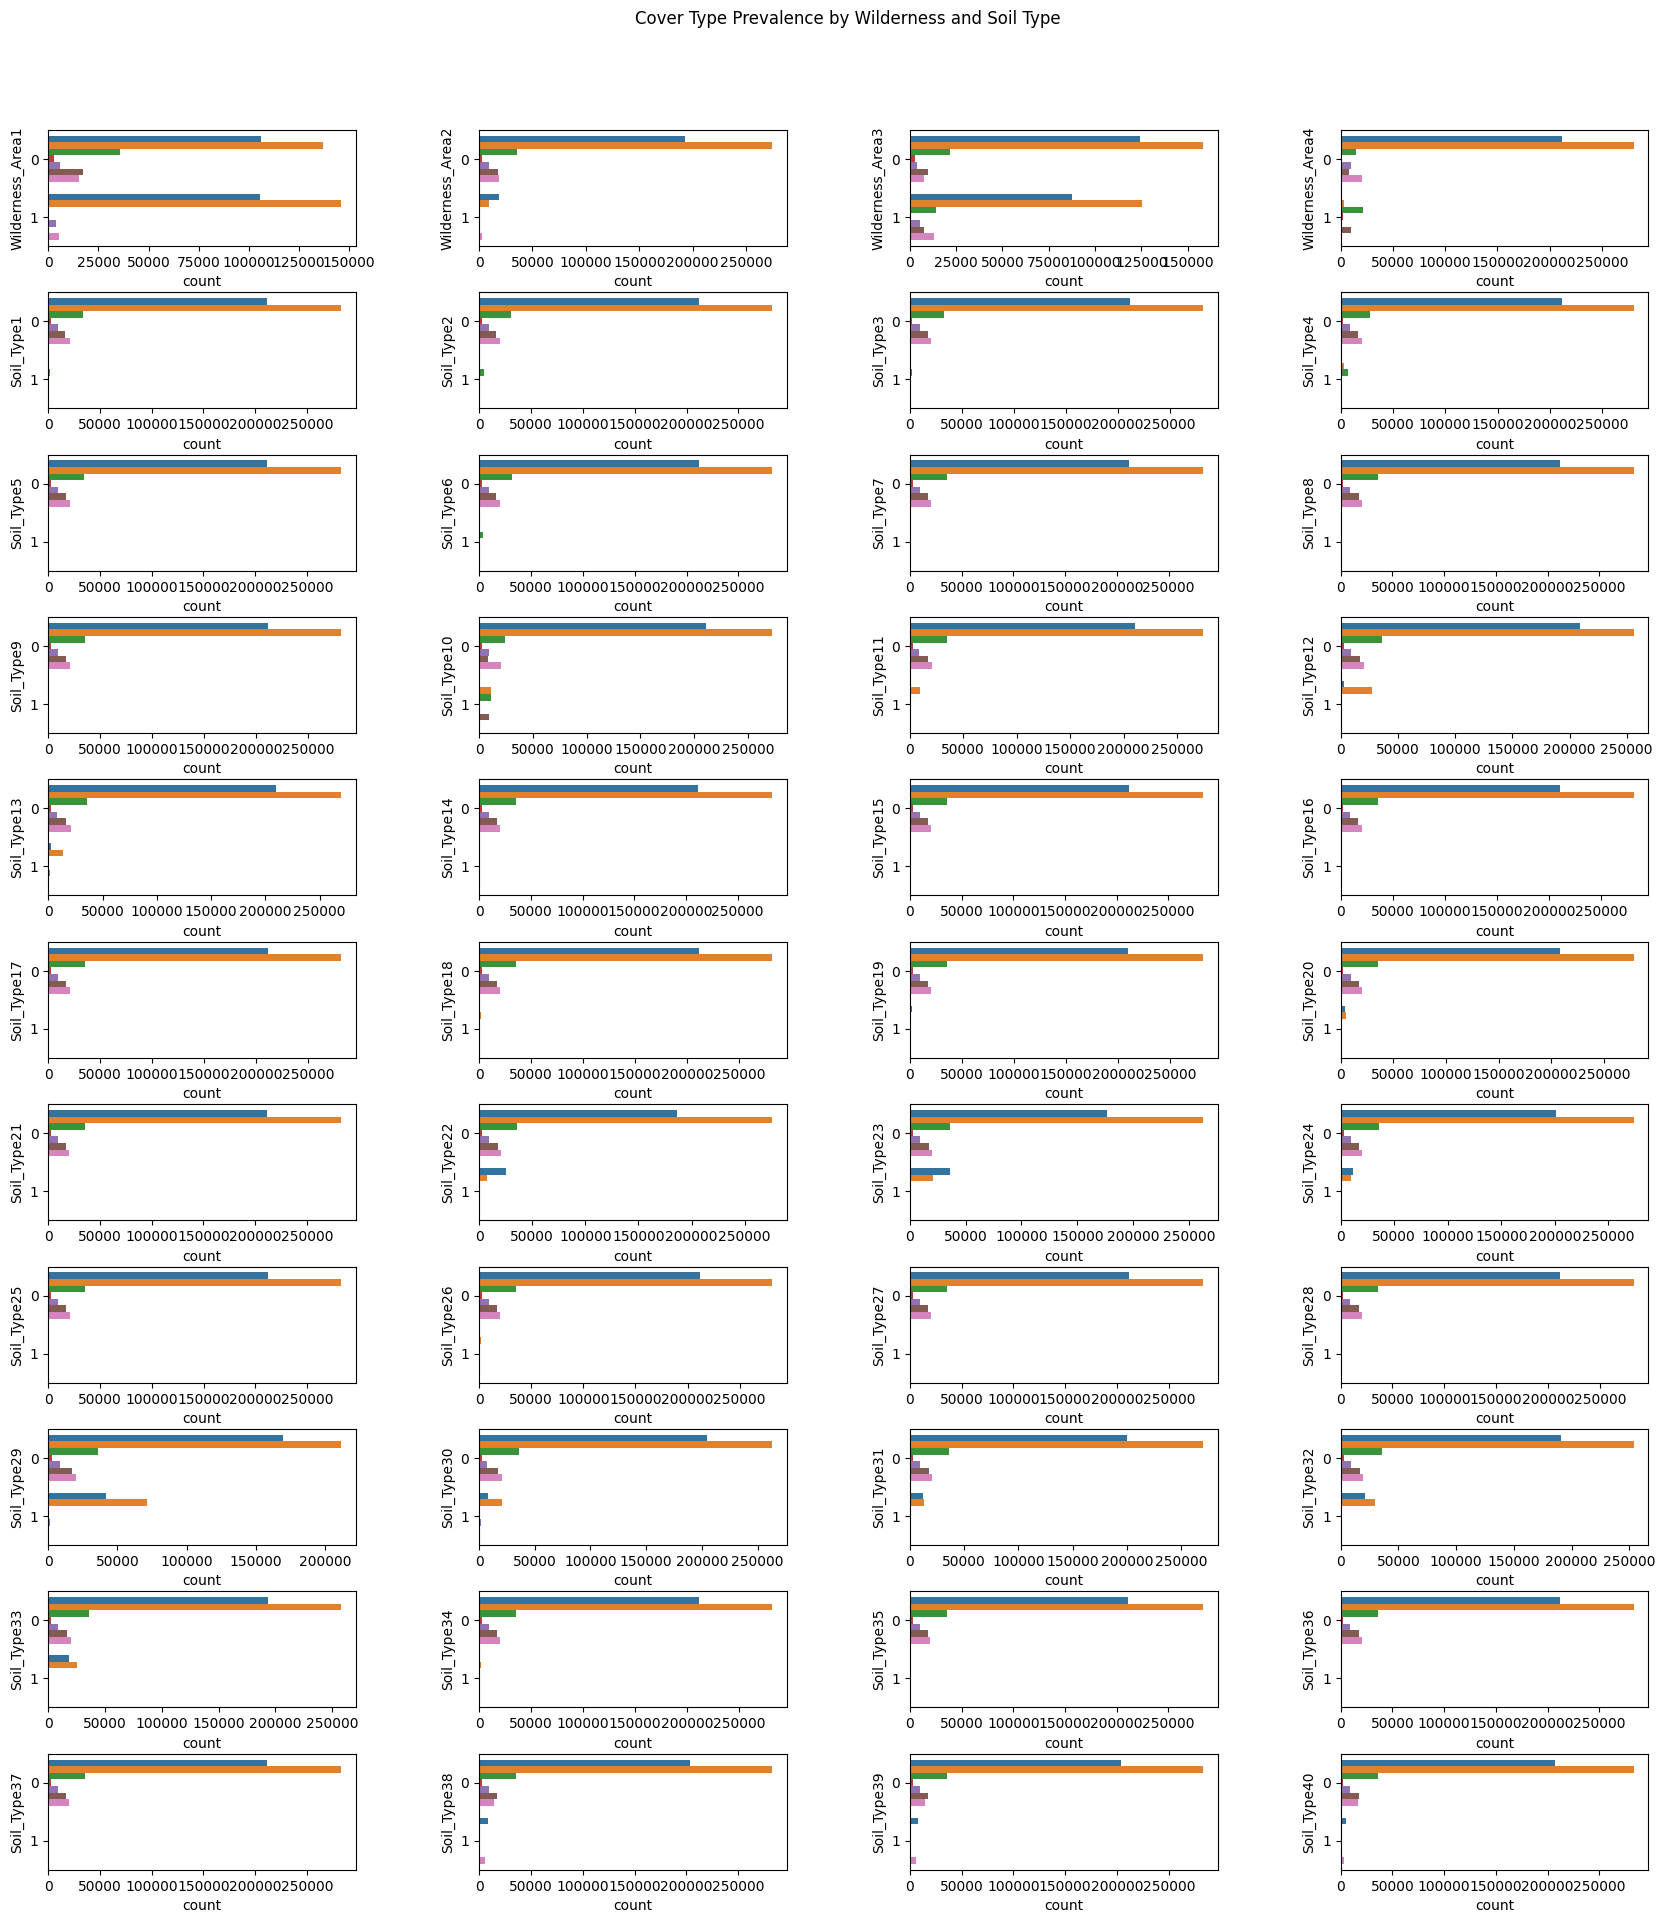

In [7]:
data = df.filter(regex = "Soil|Wilderness")
data["Cover_Type"] = df.Cover_Type

fig, axs = plt.subplots(11, 4, figsize = (20,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=3,
                    wspace=0.4,
                    hspace=0.4)

for i in range(11):
    for j in range(0,4):
        if 4*i + j >= 40:
            sns.countplot(ax = axs[i,j], y = data.columns[4*i+j], data = data, hue = "Cover_Type").legend().remove()
        else:
            sns.countplot(ax = axs[i,j], y = data.columns[4*i+j], data = data, hue = "Cover_Type").legend().remove()

plt.suptitle("Cover Type Prevalence by Wilderness and Soil Type", y = 3.2);

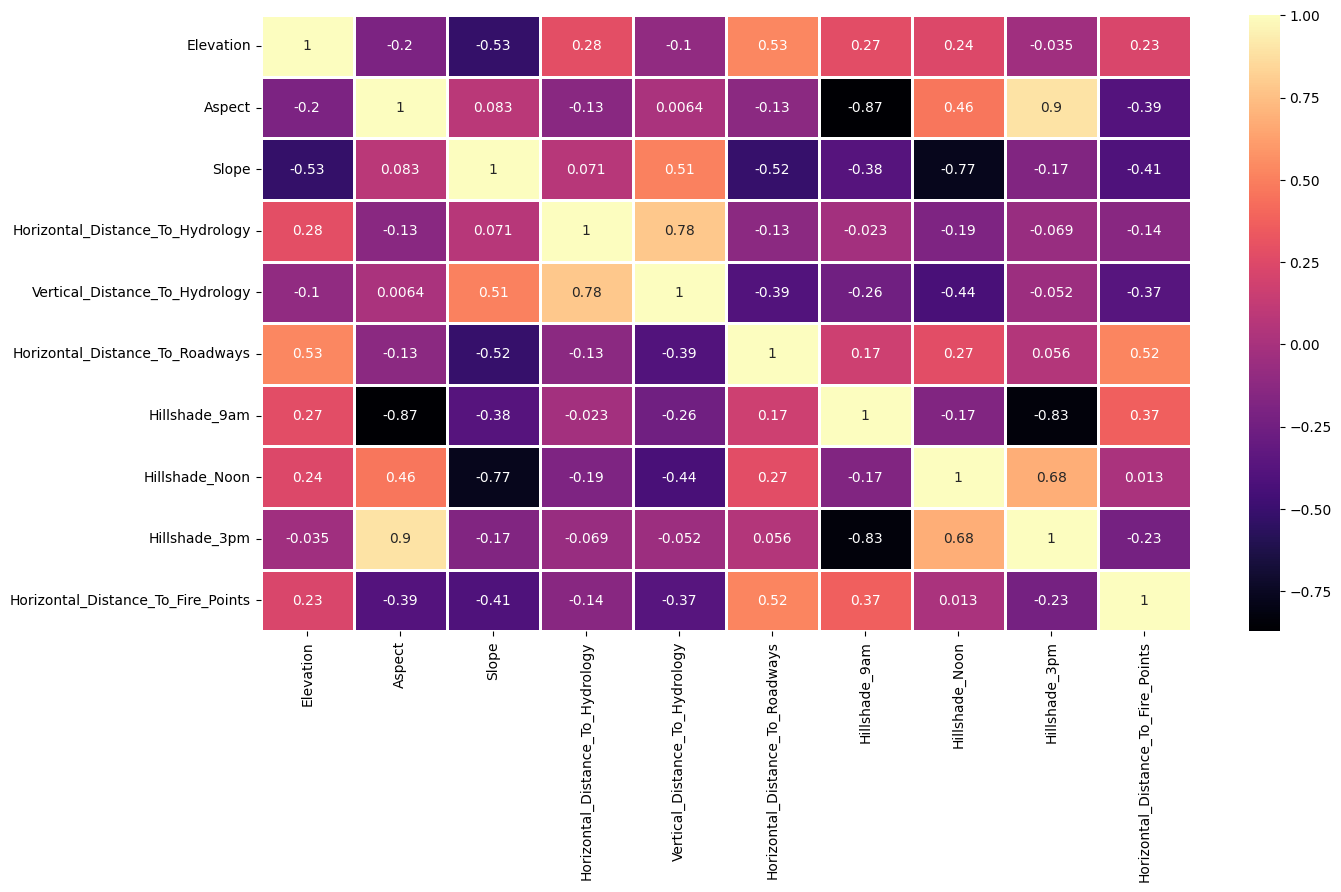

In [8]:
cor_mat = df[NUM_VARS].corr()
plt.figure(figsize=(15,8))
sns.heatmap(cor_mat.corr(),cmap='magma',linecolor='white',linewidths=1,annot=True);

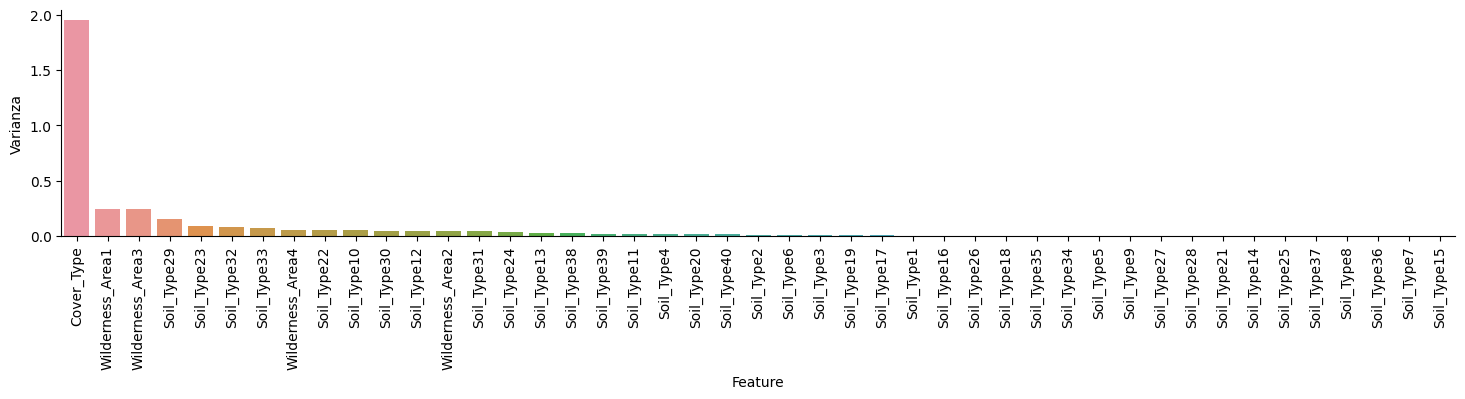

In [9]:
data = df[CAT_VARS].var().sort_values(ascending=False).reset_index().rename(columns = {'index':'Feature', 0:'Varianza'})
sns.catplot(x = "Feature", y = "Varianza", data = data, kind = "bar", errorbar = None, height = 3, aspect = 5)
plt.xticks(rotation=90);

In [10]:
REMOVE_VARS = ['Hillshade_3pm', 'Hillshade_Noon', "Soil_Type2",
"Soil_Type6",
"Soil_Type3",
"Soil_Type19",
"Soil_Type17",
"Soil_Type1",
"Soil_Type16",
"Soil_Type26",
"Soil_Type18",
"Soil_Type35",
"Soil_Type34",
"Soil_Type5",
"Soil_Type9",
"Soil_Type27",
"Soil_Type28",
"Soil_Type21",
"Soil_Type14",
"Soil_Type25",
"Soil_Type37",
"Soil_Type8",
"Soil_Type36",
"Soil_Type7",
"Soil_Type15",]

## Modelamiento

Este Notebook contiene el modelo conlos parámetros que entregaron los mejores resultados solamente.

In [11]:
X = df.drop(columns = ["Cover_Type"])#+REMOVE_VARS) # Remover variables terminó no dando tan buenos resultados
y = df.Cover_Type -1 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

sc = StandardScaler()

X_train = torch.from_numpy(sc.fit_transform(X_train)).float()
y_train = torch.from_numpy(y_train.values).long()
X_val = torch.from_numpy(sc.transform(X_val)).float()
y_val = torch.from_numpy(y_val.values).long()


In [12]:
X_train.shape, X_val.shape

(torch.Size([464809, 54]), torch.Size([116203, 54]))

## Entrenamiento

In [13]:
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
dm = CoverTypeDataModule(X_train, y_train, X_val, y_val, batch_size=1024, split_seed=42)
model = MLP()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    fast_dev_run=False,
    callbacks=[mc, early_stop],
     )
trainer.fit(model, dm)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | Sequential       | 8.7 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
8.7 K    

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 454: 'val_loss' reached 0.60545 (best 0.60545), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=0-step=454.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 908: 'val_loss' reached 0.53924 (best 0.53924), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=1-step=908.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 1362: 'val_loss' reached 0.49328 (best 0.49328), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=2-step=1362.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 1816: 'val_loss' reached 0.45911 (best 0.45911), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=3-step=1816.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 2270: 'val_loss' reached 0.42759 (best 0.42759), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=4-step=2270.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 2724: 'val_loss' reached 0.40401 (best 0.40401), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=5-step=2724.ckpt' as top 1


A Jupyter Widget

Epoch 6, global step 3178: 'val_loss' reached 0.38564 (best 0.38564), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=6-step=3178.ckpt' as top 1


A Jupyter Widget

Epoch 7, global step 3632: 'val_loss' reached 0.36937 (best 0.36937), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=7-step=3632.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 4086: 'val_loss' reached 0.35387 (best 0.35387), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=8-step=4086.ckpt' as top 1


A Jupyter Widget

Epoch 9, global step 4540: 'val_loss' reached 0.34219 (best 0.34219), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=9-step=4540.ckpt' as top 1


A Jupyter Widget

Epoch 10, global step 4994: 'val_loss' reached 0.33057 (best 0.33057), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=10-step=4994.ckpt' as top 1


A Jupyter Widget

Epoch 11, global step 5448: 'val_loss' reached 0.32018 (best 0.32018), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=11-step=5448.ckpt' as top 1


A Jupyter Widget

Epoch 12, global step 5902: 'val_loss' reached 0.31134 (best 0.31134), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=12-step=5902.ckpt' as top 1


A Jupyter Widget

Epoch 13, global step 6356: 'val_loss' reached 0.30331 (best 0.30331), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=13-step=6356.ckpt' as top 1


A Jupyter Widget

Epoch 14, global step 6810: 'val_loss' reached 0.29907 (best 0.29907), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=14-step=6810.ckpt' as top 1


A Jupyter Widget

Epoch 15, global step 7264: 'val_loss' reached 0.29146 (best 0.29146), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=15-step=7264.ckpt' as top 1


A Jupyter Widget

Epoch 16, global step 7718: 'val_loss' reached 0.28486 (best 0.28486), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=16-step=7718.ckpt' as top 1


A Jupyter Widget

Epoch 17, global step 8172: 'val_loss' reached 0.27978 (best 0.27978), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=17-step=8172.ckpt' as top 1


A Jupyter Widget

Epoch 18, global step 8626: 'val_loss' reached 0.27402 (best 0.27402), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=18-step=8626.ckpt' as top 1


A Jupyter Widget

Epoch 19, global step 9080: 'val_loss' reached 0.26937 (best 0.26937), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=19-step=9080.ckpt' as top 1


A Jupyter Widget

Epoch 20, global step 9534: 'val_loss' reached 0.26591 (best 0.26591), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=20-step=9534.ckpt' as top 1


A Jupyter Widget

Epoch 21, global step 9988: 'val_loss' reached 0.26028 (best 0.26028), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=21-step=9988.ckpt' as top 1


A Jupyter Widget

Epoch 22, global step 10442: 'val_loss' reached 0.25710 (best 0.25710), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=22-step=10442.ckpt' as top 1


A Jupyter Widget

Epoch 23, global step 10896: 'val_loss' reached 0.25395 (best 0.25395), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=23-step=10896.ckpt' as top 1


A Jupyter Widget

Epoch 24, global step 11350: 'val_loss' reached 0.24985 (best 0.24985), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=24-step=11350.ckpt' as top 1


A Jupyter Widget

Epoch 25, global step 11804: 'val_loss' reached 0.24765 (best 0.24765), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=25-step=11804.ckpt' as top 1


A Jupyter Widget

Epoch 26, global step 12258: 'val_loss' reached 0.24297 (best 0.24297), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=26-step=12258.ckpt' as top 1


A Jupyter Widget

Epoch 27, global step 12712: 'val_loss' reached 0.24143 (best 0.24143), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=27-step=12712.ckpt' as top 1


A Jupyter Widget

Epoch 28, global step 13166: 'val_loss' reached 0.23746 (best 0.23746), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=28-step=13166.ckpt' as top 1


A Jupyter Widget

Epoch 29, global step 13620: 'val_loss' reached 0.23593 (best 0.23593), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=29-step=13620.ckpt' as top 1


A Jupyter Widget

Epoch 30, global step 14074: 'val_loss' reached 0.23263 (best 0.23263), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=30-step=14074.ckpt' as top 1


A Jupyter Widget

Epoch 31, global step 14528: 'val_loss' reached 0.23231 (best 0.23231), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=31-step=14528.ckpt' as top 1


A Jupyter Widget

Epoch 32, global step 14982: 'val_loss' reached 0.22819 (best 0.22819), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=32-step=14982.ckpt' as top 1


A Jupyter Widget

Epoch 33, global step 15436: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 34, global step 15890: 'val_loss' reached 0.22491 (best 0.22491), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=34-step=15890.ckpt' as top 1


A Jupyter Widget

Epoch 35, global step 16344: 'val_loss' reached 0.22300 (best 0.22300), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=35-step=16344.ckpt' as top 1


A Jupyter Widget

Epoch 36, global step 16798: 'val_loss' reached 0.22075 (best 0.22075), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=36-step=16798.ckpt' as top 1


A Jupyter Widget

Epoch 37, global step 17252: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 38, global step 17706: 'val_loss' reached 0.21874 (best 0.21874), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=38-step=17706.ckpt' as top 1


A Jupyter Widget

Epoch 39, global step 18160: 'val_loss' reached 0.21549 (best 0.21549), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=39-step=18160.ckpt' as top 1


A Jupyter Widget

Epoch 40, global step 18614: 'val_loss' reached 0.21445 (best 0.21445), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=40-step=18614.ckpt' as top 1


A Jupyter Widget

Epoch 41, global step 19068: 'val_loss' reached 0.21355 (best 0.21355), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=41-step=19068.ckpt' as top 1


A Jupyter Widget

Epoch 42, global step 19522: 'val_loss' reached 0.21008 (best 0.21008), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=42-step=19522.ckpt' as top 1


A Jupyter Widget

Epoch 43, global step 19976: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 44, global step 20430: 'val_loss' reached 0.20844 (best 0.20844), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=44-step=20430.ckpt' as top 1


A Jupyter Widget

Epoch 45, global step 20884: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 46, global step 21338: 'val_loss' reached 0.20668 (best 0.20668), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=46-step=21338.ckpt' as top 1


A Jupyter Widget

Epoch 47, global step 21792: 'val_loss' reached 0.20655 (best 0.20655), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=47-step=21792.ckpt' as top 1


A Jupyter Widget

Epoch 48, global step 22246: 'val_loss' reached 0.20305 (best 0.20305), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=48-step=22246.ckpt' as top 1


A Jupyter Widget

Epoch 49, global step 22700: 'val_loss' reached 0.20146 (best 0.20146), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=49-step=22700.ckpt' as top 1


A Jupyter Widget

Epoch 50, global step 23154: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 51, global step 23608: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 52, global step 24062: 'val_loss' reached 0.20075 (best 0.20075), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=52-step=24062.ckpt' as top 1


A Jupyter Widget

Epoch 53, global step 24516: 'val_loss' reached 0.19782 (best 0.19782), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=53-step=24516.ckpt' as top 1


A Jupyter Widget

Epoch 54, global step 24970: 'val_loss' reached 0.19765 (best 0.19765), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=54-step=24970.ckpt' as top 1


A Jupyter Widget

Epoch 55, global step 25424: 'val_loss' reached 0.19615 (best 0.19615), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=55-step=25424.ckpt' as top 1


A Jupyter Widget

Epoch 56, global step 25878: 'val_loss' reached 0.19499 (best 0.19499), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=56-step=25878.ckpt' as top 1


A Jupyter Widget

Epoch 57, global step 26332: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 58, global step 26786: 'val_loss' reached 0.19434 (best 0.19434), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=58-step=26786.ckpt' as top 1


A Jupyter Widget

Epoch 59, global step 27240: 'val_loss' reached 0.19331 (best 0.19331), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=59-step=27240.ckpt' as top 1


A Jupyter Widget

Epoch 60, global step 27694: 'val_loss' reached 0.19291 (best 0.19291), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=60-step=27694.ckpt' as top 1


A Jupyter Widget

Epoch 61, global step 28148: 'val_loss' reached 0.19122 (best 0.19122), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=61-step=28148.ckpt' as top 1


A Jupyter Widget

Epoch 62, global step 28602: 'val_loss' reached 0.19038 (best 0.19038), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=62-step=28602.ckpt' as top 1


A Jupyter Widget

Epoch 63, global step 29056: 'val_loss' reached 0.19002 (best 0.19002), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=63-step=29056.ckpt' as top 1


A Jupyter Widget

Epoch 64, global step 29510: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 65, global step 29964: 'val_loss' reached 0.18920 (best 0.18920), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=65-step=29964.ckpt' as top 1


A Jupyter Widget

Epoch 66, global step 30418: 'val_loss' reached 0.18754 (best 0.18754), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=66-step=30418.ckpt' as top 1


A Jupyter Widget

Epoch 67, global step 30872: 'val_loss' reached 0.18633 (best 0.18633), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=67-step=30872.ckpt' as top 1


A Jupyter Widget

Epoch 68, global step 31326: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 69, global step 31780: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 70, global step 32234: 'val_loss' reached 0.18493 (best 0.18493), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=70-step=32234.ckpt' as top 1


A Jupyter Widget

Epoch 71, global step 32688: 'val_loss' reached 0.18459 (best 0.18459), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=71-step=32688.ckpt' as top 1


A Jupyter Widget

Epoch 72, global step 33142: 'val_loss' reached 0.18388 (best 0.18388), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=72-step=33142.ckpt' as top 1


A Jupyter Widget

Epoch 73, global step 33596: 'val_loss' reached 0.18387 (best 0.18387), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=73-step=33596.ckpt' as top 1


A Jupyter Widget

Epoch 74, global step 34050: 'val_loss' reached 0.18342 (best 0.18342), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=74-step=34050.ckpt' as top 1


A Jupyter Widget

Epoch 75, global step 34504: 'val_loss' reached 0.18281 (best 0.18281), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=75-step=34504.ckpt' as top 1


A Jupyter Widget

Epoch 76, global step 34958: 'val_loss' reached 0.18214 (best 0.18214), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=76-step=34958.ckpt' as top 1


A Jupyter Widget

Epoch 77, global step 35412: 'val_loss' reached 0.18099 (best 0.18099), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=77-step=35412.ckpt' as top 1


A Jupyter Widget

Epoch 78, global step 35866: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 79, global step 36320: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 80, global step 36774: 'val_loss' reached 0.17948 (best 0.17948), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=80-step=36774.ckpt' as top 1


A Jupyter Widget

Epoch 81, global step 37228: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 82, global step 37682: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 83, global step 38136: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 84, global step 38590: 'val_loss' reached 0.17765 (best 0.17765), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=84-step=38590.ckpt' as top 1


A Jupyter Widget

Epoch 85, global step 39044: 'val_loss' reached 0.17615 (best 0.17615), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=85-step=39044.ckpt' as top 1


A Jupyter Widget

Epoch 86, global step 39498: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 87, global step 39952: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 88, global step 40406: 'val_loss' reached 0.17572 (best 0.17572), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=88-step=40406.ckpt' as top 1


A Jupyter Widget

Epoch 89, global step 40860: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 90, global step 41314: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 91, global step 41768: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 92, global step 42222: 'val_loss' reached 0.17497 (best 0.17497), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=92-step=42222.ckpt' as top 1


A Jupyter Widget

Epoch 93, global step 42676: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 94, global step 43130: 'val_loss' reached 0.17310 (best 0.17310), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=94-step=43130.ckpt' as top 1


A Jupyter Widget

Epoch 95, global step 43584: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 96, global step 44038: 'val_loss' reached 0.17284 (best 0.17284), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=96-step=44038.ckpt' as top 1


A Jupyter Widget

Epoch 97, global step 44492: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 98, global step 44946: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 99, global step 45400: 'val_loss' reached 0.17149 (best 0.17149), saving model to '/home/datacuber/Documents/MSDS/Neural Net/checkpoints/epoch=99-step=45400.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


## Validación

In [14]:
model = MLP.load_from_checkpoint("checkpoints/best-checkpoint-latest.ckpt")
@torch.inference_mode()
def predict(model, dm):
    model.eval()
    preds = []
    for item in dm.val_dataloader():
        
        pred = model(item[0])
        preds.extend(pred.cpu().detach().numpy())
        
    return preds

In [15]:
import numpy as np
result = predict(model, dm)
y_pred = np.argmax(np.array(result), axis= 1)
print(f"Accuracy Score {accuracy_score(y_val.numpy(), y_pred)}")
print(f"F1 Score {f1_score(y_val.numpy(), y_pred, average='macro')}")

Accuracy Score 0.9347865373527362
F1 Score 0.8958328098729045
